<a href="https://colab.research.google.com/github/yjb-git/colab/blob/main/LoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np

def log_filter(gray, sigma=1.6, ksize=None, normalize=True):
    """
    Laplacian of Gaussian:
      1) Gaussian blur with sigma
      2) Laplacian (2nd derivative)
    Args:
      gray: uint8 or float32 2D image
      sigma: Gaussian std
      ksize: Gaussian kernel size (odd). If None, choose from sigma.
      normalize: if True, apply scale-normalized LoG (multiply by sigma^2)
    Returns:
      log_img: float32 LoG response
    """
    if gray.ndim != 2:
        raise ValueError("gray must be a single-channel (H,W) image")

    gray_f = gray.astype(np.float32)

    if ksize is None:
        # rule of thumb: cover ~3 sigma on each side -> 6*sigma+1
        ksize = int(np.ceil(sigma * 6)) | 1  # make it odd

    blur = cv2.GaussianBlur(gray_f, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    # Laplacian: second derivatives sum (∂²/∂x² + ∂²/∂y²)
    log_img = cv2.Laplacian(blur, ddepth=cv2.CV_32F, ksize=3)

    # Scale-normalized LoG (important for scale invariance)
    if normalize:
        log_img = (sigma ** 2) * log_img

    return log_img

In [ ]:
mountain_path = '/content/drive/MyDrive/mountain.jpg'

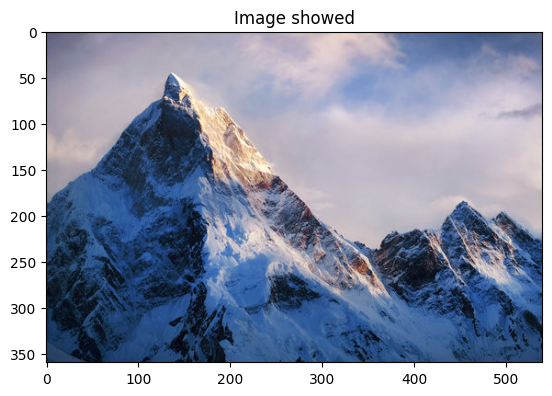

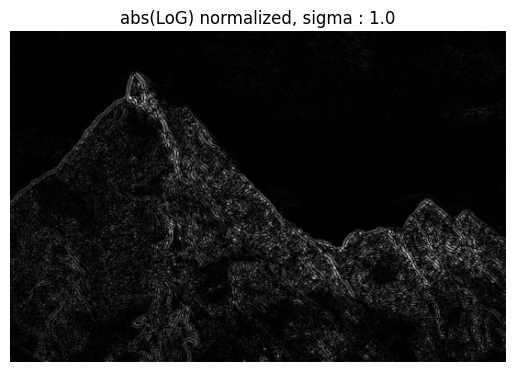

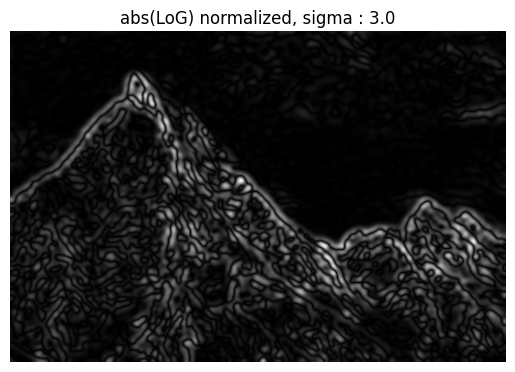

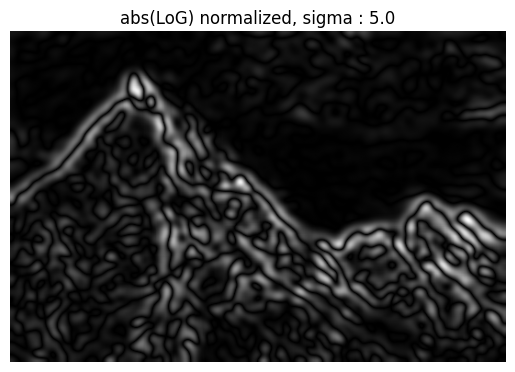

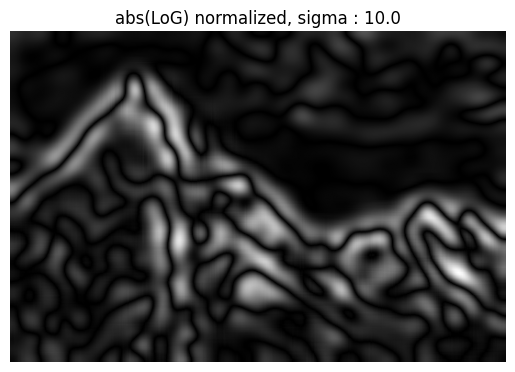

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cv2.imread(mountain_path), cv2.COLOR_BGR2RGB))
plt.title("Image showed")
plt.show()
gray = cv2.imread(mountain_path, cv2.IMREAD_GRAYSCALE)
for sigma in ([1.0, 3.0, 5.0, 10.0]) :
  resp = log_filter(gray, sigma=sigma, normalize=True)

  vis = np.abs(resp)
  vis = cv2.normalize(vis, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

  plt.imshow(vis, cmap="gray")
  plt.title(f"abs(LoG) normalized, sigma : {sigma}")
  plt.axis("off")
  plt.show()

In [ ]:
import cv2
import numpy as np

def dog_filter(gray, sigma=1.6, k=np.sqrt(2), ksize=None, normalize=True):
    """
    Difference of Gaussians (DoG) approximates scale-normalized LoG:
      DoG = G(k*sigma) * I - G(sigma) * I
    Args:
      sigma: base sigma
      k: scale step
      normalize: optional; DoG already behaves like sigma^2*LoG up to constant factor
    """
    if gray.ndim != 2:
        raise ValueError("gray must be a single-channel (H,W) image")

    gray_f = gray.astype(np.float32)

    if ksize is None:
        ksize = int(np.ceil((k*sigma) * 6)) | 1

    g1 = cv2.GaussianBlur(gray_f, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)
    g2 = cv2.GaussianBlur(gray_f, (ksize, ksize), sigmaX=k*sigma, sigmaY=k*sigma)

    dog = g2 - g1

    # optional: match sign/scale conventions if you want (usually not necessary)
    if normalize:
        # some people multiply by sigma^2 to compare with LoG; constant factors don't matter for extrema
        dog = (sigma ** 2) * dog

    return dog

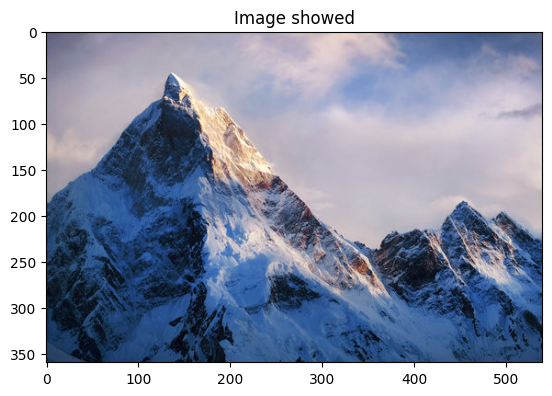

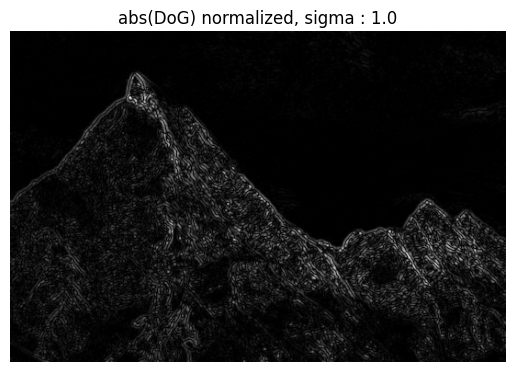

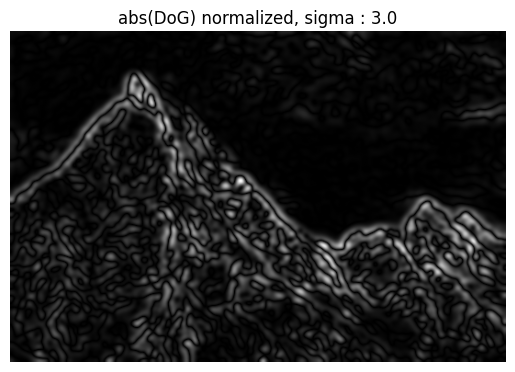

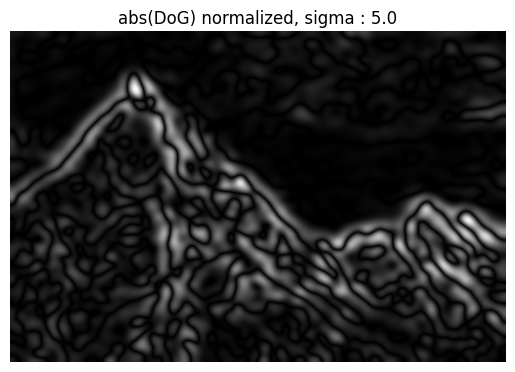

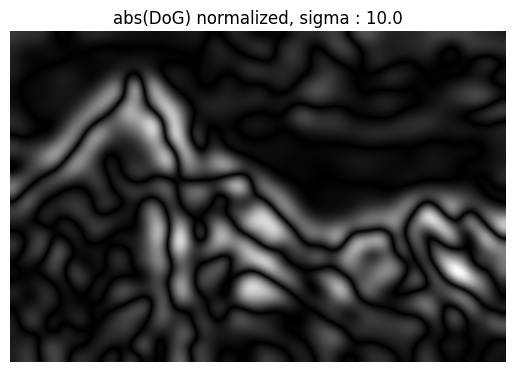

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cv2.imread(mountain_path), cv2.COLOR_BGR2RGB))
plt.title("Image showed")
plt.show()
gray = cv2.imread(mountain_path, cv2.IMREAD_GRAYSCALE)
for sigma in ([1.0, 3.0, 5.0, 10.0]) :
  resp = dog_filter(gray, sigma=sigma, normalize=True)

  vis = np.abs(resp)
  vis = cv2.normalize(vis, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

  plt.imshow(vis, cmap="gray")
  plt.title(f"abs(DoG) normalized, sigma : {sigma}")
  plt.axis("off")
  plt.show()

In [ ]:
import cv2
import numpy as np


def build_gaussian_pyramid(gray, num_octaves=4, n_scales=3, sigma0=1.6):
    """
    Build Gaussian pyramid like SIFT.
    Returns:
      gauss_pyr: list of octaves, each is list of Gaussian images [0..n_scales+2]
      sigmas:    list of octaves, each is list of sigma for each Gaussian level
    """
    if gray.ndim != 2:
        raise ValueError("gray must be a single-channel (H,W) image")

    base = gray.astype(np.float32)

    # SIFT typically uses k = 2^(1/n_scales)
    k = 2 ** (1.0 / n_scales)

    gauss_pyr = []
    sigmas_pyr = []

    for o in range(num_octaves):
        # For octave 0: use base; for next octaves: downsample previous octave's level n_scales
        if o == 0:
            octave_base = base
        else:
            prev_octave = gauss_pyr[o - 1]
            # Downsample from a mid/high blur level for stability (commonly level n_scales)
            octave_base = cv2.resize(prev_octave[n_scales], (prev_octave[n_scales].shape[1] // 2,
                                                            prev_octave[n_scales].shape[0] // 2),
                                     interpolation=cv2.INTER_NEAREST)

        # Gaussian levels per octave: n_scales + 3 (SIFT convention)
        gaussians = []
        sigmas = []

        # level 0 sigma is sigma0 (conceptually). We'll blur relative to current image.
        # Practical implementation: build each level by additional blur from previous.
        gaussians.append(octave_base)
        sigmas.append(sigma0)

        for s in range(1, n_scales + 3):
            sigma_prev = sigma0 * (k ** (s - 1))
            sigma_total = sigma0 * (k ** s)

            # incremental blur sigma: sqrt(total^2 - prev^2)
            sigma_inc = np.sqrt(max(sigma_total * sigma_total - sigma_prev * sigma_prev, 1e-10))

            ksize = int(np.ceil(sigma_inc * 6)) | 1
            blurred = cv2.GaussianBlur(gaussians[-1], (ksize, ksize), sigmaX=sigma_inc, sigmaY=sigma_inc)
            gaussians.append(blurred)
            sigmas.append(sigma_total)

        gauss_pyr.append(gaussians)
        sigmas_pyr.append(sigmas)

    return gauss_pyr, sigmas_pyr


def build_dog_pyramid(gauss_pyr):
    """
    DoG octave: DoG[s] = G[s+1] - G[s]
    Returns:
      dog_pyr: list of octaves, each is list of DoG images [0..n_scales+1]
    """
    dog_pyr = []
    for gaussians in gauss_pyr:
        dogs = []
        for i in range(len(gaussians) - 1):
            dogs.append(gaussians[i + 1] - gaussians[i])
        dog_pyr.append(dogs)
    return dog_pyr


def _is_3d_extremum(dog_prev, dog_cur, dog_next, x, y, th, find_max=True):
    """
    Check if dog_cur[y,x] is strict extremum in 3x3x3 neighborhood (excluding center),
    with contrast threshold th (|val| >= th).
    """
    val = dog_cur[y, x]
    if abs(val) < th:
        return False

    # extract 3x3 patches
    p_prev = dog_prev[y - 1:y + 2, x - 1:x + 2]
    p_cur  = dog_cur [y - 1:y + 2, x - 1:x + 2]
    p_next = dog_next[y - 1:y + 2, x - 1:x + 2]

    if find_max:
        # center must be > all others
        if val <= p_prev.max(): return False
        # for current patch, exclude center
        if val <= np.max(p_cur[np.array([[1,1],[1,1]])] if False else p_cur):  # ignore; we'll explicit below
            pass
        # explicit exclude center
        p_cur_max = p_cur.copy()
        p_cur_max[1, 1] = -np.inf
        if val <= p_cur_max.max(): return False
        if val <= p_next.max(): return False
        return True
    else:
        # center must be < all others
        if val >= p_prev.min(): return False
        p_cur_min = p_cur.copy()
        p_cur_min[1, 1] = np.inf
        if val >= p_cur_min.min(): return False
        if val >= p_next.min(): return False
        return True


def _passes_edge_response_test(dog, x, y, r=10.0):
    """
    SIFT-like edge response elimination using Hessian of DoG at (x,y).
    Reject if (Tr(H)^2 / Det(H)) >= ((r+1)^2 / r).
    """
    # second derivatives (finite differences)
    Dxx = dog[y, x + 1] + dog[y, x - 1] - 2.0 * dog[y, x]
    Dyy = dog[y + 1, x] + dog[y - 1, x] - 2.0 * dog[y, x]
    Dxy = (dog[y + 1, x + 1] - dog[y + 1, x - 1] - dog[y - 1, x + 1] + dog[y - 1, x - 1]) / 4.0

    tr = Dxx + Dyy
    det = Dxx * Dyy - Dxy * Dxy

    if det <= 1e-12:
        return False

    ratio = (tr * tr) / det
    threshold = ((r + 1.0) * (r + 1.0)) / r
    return ratio < threshold


def find_dog_keypoints_3d(dog_pyr, sigmas_pyr, n_scales=3,
                          contrast_th=0.03, edge_r=10.0,
                          border=1):
    """
    Find 3D extrema in DoG scale-space.
    Args:
      dog_pyr: output of build_dog_pyramid
      sigmas_pyr: sigmas per Gaussian level (from build_gaussian_pyramid)
      n_scales: number of "intervals" per octave (SIFT default 3)
      contrast_th: contrast threshold on |DoG|
      edge_r: edge response elimination parameter (SIFT uses r=10)
      border: ignore pixels within this border (need >=1 for 3x3)
    Returns:
      keypoints: list of dicts with fields:
        octave, scale (DoG scale index), x, y, sigma, value
      Notes:
        - (x,y) are coordinates in that octave's image (not mapped to original).
        - sigma is the Gaussian sigma corresponding to the *Gaussian level* (scale+1).
    """
    keypoints = []

    for o, dogs in enumerate(dog_pyr):
        # DoG has length n_scales+2 (because Gaussian is n_scales+3)
        # extrema search on DoG scales 1..n_scales (exclude 0 and last)
        H, W = dogs[0].shape

        for s in range(1, n_scales + 1):
            dog_prev = dogs[s - 1]
            dog_cur  = dogs[s]
            dog_next = dogs[s + 1]

            # sigma for this DoG level: commonly relate to Gaussian level s+1
            # (since DoG[s] = G[s+1]-G[s])
            sigma = sigmas_pyr[o][s + 1]

            for y in range(border, H - border):
                for x in range(border, W - border):
                    # check maxima or minima in 3D neighborhood
                    if _is_3d_extremum(dog_prev, dog_cur, dog_next, x, y, contrast_th, find_max=True) or \
                       _is_3d_extremum(dog_prev, dog_cur, dog_next, x, y, contrast_th, find_max=False):

                        # optional edge response elimination (very important)
                        if edge_r is not None and edge_r > 0:
                            if not _passes_edge_response_test(dog_cur, x, y, r=edge_r):
                                continue

                        keypoints.append({
                            "octave": o,
                            "scale": s,     # DoG scale index inside octave
                            "x": x,
                            "y": y,
                            "sigma": float(sigma),
                            "value": float(dog_cur[y, x]),
                        })

    return keypoints

In [ ]:
gray = cv2.imread(mountain_path, cv2.IMREAD_GRAYSCALE)

gauss_pyr, sigmas_pyr = build_gaussian_pyramid(gray, num_octaves=4, n_scales=4, sigma0=1.6)
dog_pyr = build_dog_pyramid(gauss_pyr)

kps = find_dog_keypoints_3d(
    dog_pyr, sigmas_pyr,
    n_scales=4,
    contrast_th=4,   # 이미지 스케일에 따라 조정
    edge_r=4.0,
    border=1
)

print("num keypoints:", len(kps))
print(kps[:5])

num keypoints: 72
[{'octave': 0, 'scale': 2, 'x': 152, 'y': 144, 'sigma': 2.6908685288118868, 'value': -4.980873107910156}, {'octave': 0, 'scale': 2, 'x': 157, 'y': 190, 'sigma': 2.6908685288118868, 'value': 5.024265289306641}, {'octave': 0, 'scale': 2, 'x': 401, 'y': 230, 'sigma': 2.6908685288118868, 'value': 5.080924987792969}, {'octave': 0, 'scale': 2, 'x': 145, 'y': 272, 'sigma': 2.6908685288118868, 'value': -6.201324462890625}, {'octave': 0, 'scale': 3, 'x': 67, 'y': 137, 'sigma': 3.1999999999999997, 'value': 6.028411865234375}]


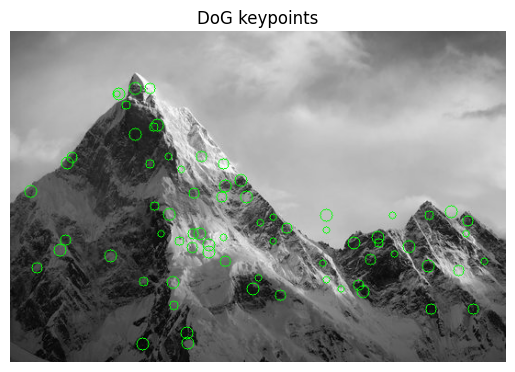

In [ ]:
import matplotlib.pyplot as plt

vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

for kp in kps:
    o = kp["octave"]
    x0 = int(kp["x"] * (2 ** o))
    y0 = int(kp["y"] * (2 ** o))
    r  = int(2.0 * kp["sigma"])  # 대충 스케일 느낌으로 반지름
    cv2.circle(vis, (x0, y0), max(r, 2), (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
plt.title("DoG keypoints")
plt.axis("off") # Turn off axis for image display
plt.show()